
[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


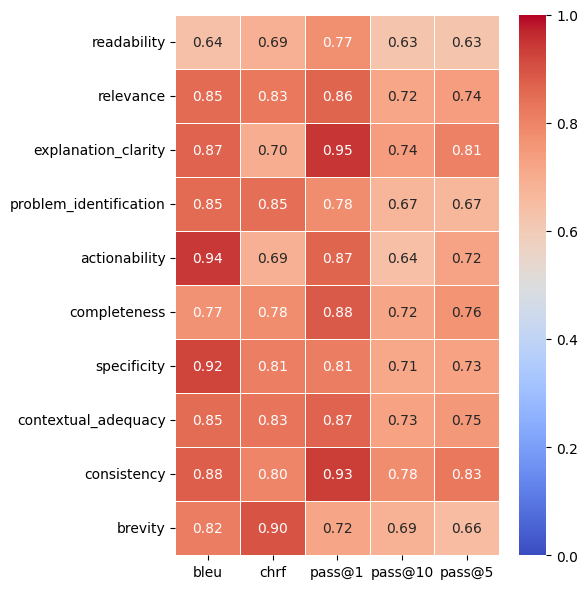

In [ ]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import json
import ast


models = [
    "qwen3-235b-a22b",
    "gpt-4o",
    "gpt-4o-mini",
    "qwq-32b",
    "o3-mini",
    "claude-3.7-sonnet",
    "deepseek-r1",
    "qwen2.5-coder-32b-instruct",
]

all_metrics = {}
for model in models:
    res = pd.read_csv(model + ".csv")
    labels = list(res['metrics'])
    for i in range(len(labels)):
        labels[i] = ast.literal_eval(labels[i])
    metrics = pd.DataFrame(labels)
    metrics = metrics.mean(0)
    all_metrics[model] = metrics

metrics_df = pd.DataFrame(all_metrics)
metrics_df = metrics_df.transpose()

avg_multimetrics = pd.read_json('avg_multimetrics.json')
avg_multimetrics = avg_multimetrics.drop(columns=["Qwen3 30b A3b", "Human review"])
avg_multimetrics.rename(
    columns={
        'Qwen3 235b A22b': 'qwen3-235b-a22b',
        'GPT 4o': 'gpt-4o',
        'GPT 4o Mini': 'gpt-4o-mini',
        'QWQ 32b': 'qwq-32b',
        'Claude 3.7 Sonnet': 'claude-3.7-sonnet',
        'Deepseek R1': 'deepseek-r1',
        'Qwen 2.5 Coder 32b Instruct': 'qwen2.5-coder-32b-instruct'
    },
    inplace=True,
)

avg_multimetrics = avg_multimetrics.transpose()

assert (metrics_df.index == avg_multimetrics.index).all()

correlation_matrix = pd.DataFrame(index=metrics_df.columns, columns=avg_multimetrics.columns, dtype=float)
metrics_df['pass@1'] *= 100
metrics_df['pass@5'] *= 100
metrics_df['pass@10'] *= 100

for metric in metrics_df.columns:
    for colleague_metric in avg_multimetrics.columns:
        correlation, _ = pearsonr(metrics_df[metric], avg_multimetrics[colleague_metric])
        correlation_matrix.loc[metric, colleague_metric] = correlation

plt.figure(figsize=(6, 6))
sns.heatmap(correlation_matrix.T, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5, vmin=0., vmax=1.)
plt.tight_layout()
plt.savefig("metrics_corr.png", dpi=300, transparent=False, bbox_inches="tight")
plt.show()

/tmp/ipykernel_227/1232881795.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(model, (metrics_df['pass@1'][i] + 0.3, avg_multimetrics['avg_all'][i] - 0.009))


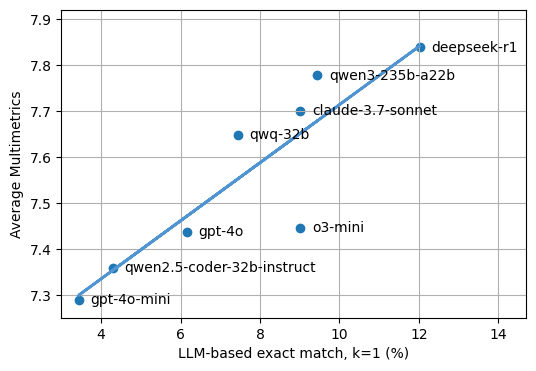

Корреляция Пирсона: 0.8826636151
P-value: 0.004


In [38]:
avg_multimetrics['avg_all'] = avg_multimetrics.mean(axis=1)

plt.figure(figsize=(6, 4))
plt.scatter(metrics_df['pass@1'], avg_multimetrics['avg_all'])
plt.xlabel('LLM-based exact match, k=1 (%)')
plt.ylabel('Average Multimetrics')
plt.xlim(3, 14.7)
plt.ylim(7.25, 7.92)

m, b = np.polyfit(metrics_df['pass@1'], avg_multimetrics['avg_all'], 1)
plt.plot(metrics_df['pass@1'], m*metrics_df['pass@1'] + b, linestyle='-', linewidth=2, color='#5094d1')

for i, model in enumerate(metrics_df.index):
    plt.annotate(model, (metrics_df['pass@1'][i] + 0.3, avg_multimetrics['avg_all'][i] - 0.009))

plt.grid(True)
plt.savefig("pass@1_vs_avg_multimetrics.png", dpi=300, transparent=False, bbox_inches="tight")
plt.show()

correlation, p_value = pearsonr(metrics_df['pass@1'], avg_multimetrics['avg_all'])
print(f"Корреляция Пирсона: {correlation:.10f}")
print(f"P-value: {p_value:.3f}")